In [1]:
from envs.train_env import Electric_Car
from models.baseline import BaselineModel
from models.baseline2 import BaselineModel2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from models.tabular_qlearning import TabularQLearning
from envs.feature_engineering import DataHelper
import torch

In [2]:
def data_analysis():
    data_path_train = 'data/train.xlsx'
    df = pd.read_excel(data_path_train)

    df['Month'] = df['PRICES'].dt.month
    df['DayOfWeek'] = df['PRICES'].dt.dayofweek
    df['AvgPerDay'] = df.iloc[:, 1:25].mean(axis=1)

    monthly_avg = df.groupby('Month')['AvgPerDay'].mean()
    day_of_week_avg = df.groupby('DayOfWeek')['AvgPerDay'].mean()
    hourly_avg = df.iloc[:, 1:25].mean()

    monthly_avg.plot(kind='bar', title='Average Price per Month',edgecolor='black')
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.show()

    day_of_week_avg.plot(kind='bar', title='Average Price per Day of the Week',edgecolor='black')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Price')
    plt.show()

    hourly_avg.plot(kind='bar', title='Average Price per Hour',edgecolor='black')
    plt.xlabel('Hour')
    plt.ylabel('Average Price')
    plt.show()


In [3]:
# dh = DataHelper()

# def learn(env, model):
#     states, rewards, infos = [], [], []
#     truncated = False
#     terminated = False
#     while(terminated == False and truncated == False):
#         action = model.predict(env)
#         obs, reward, termination, truncation, info = env.step(action)
#         new_obs = dh.process_data(obs)

#         states.append(new_obs)
#         rewards.append(reward)
#         terminated = termination
#         truncated = truncation
#         infos.append(info)

#     return states, rewards, terminated, truncated, infos

Please wait, the algorithm is learning! The current simulation is 0
Average reward  -7287.618946226028
Please wait, the algorithm is learning! The current simulation is 5
Average reward  -6847.15197934101
Please wait, the algorithm is learning! The current simulation is 10
Average reward  -6432.084715753839
Please wait, the algorithm is learning! The current simulation is 15
Average reward  -5912.907047521667
Please wait, the algorithm is learning! The current simulation is 20
Average reward  -5111.008980332667
Please wait, the algorithm is learning! The current simulation is 25
Average reward  -4502.81977251315
Please wait, the algorithm is learning! The current simulation is 30
Average reward  -3728.0841655216987
Please wait, the algorithm is learning! The current simulation is 35
Average reward  -3011.7533780770236
Please wait, the algorithm is learning! The current simulation is 40
Average reward  -2159.97282233639
Please wait, the algorithm is learning! The current simulation is 4

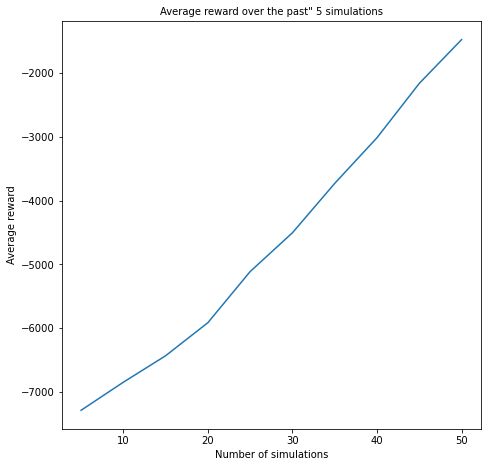

In [4]:
data_path_train = 'data/train.xlsx'
data_path_test = 'data/validate.xlsx'

simulations = 50
simulations_per_average = 5
learning_rate = 0.1
epsilon = 0.05
epsilon_decay = simulations
adaptive_epsilon = True
adapting_learning_rate = False
discount_rate = 0.9

features_Qtable = [0, 1, 2] #0 battery, 1 price, 2 hour, 3 day of week, 5 (month) 
bin_size = [6, 8, 13, 4] #bin size of features with corresponding index, last value is action space

model = TabularQLearning(data_path_train, discount_rate, bin_size, features_Qtable)
model.train(simulations, simulations_per_average, learning_rate, epsilon, epsilon_decay, adaptive_epsilon, adapting_learning_rate)
#model.create_Q_table()
#model.load_Qtable('model_checkpoints/Tabular1.npy')
model.visualize_rewards_and_performance()

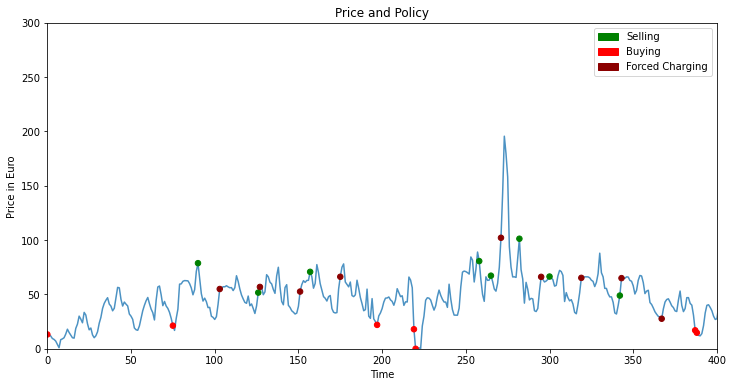

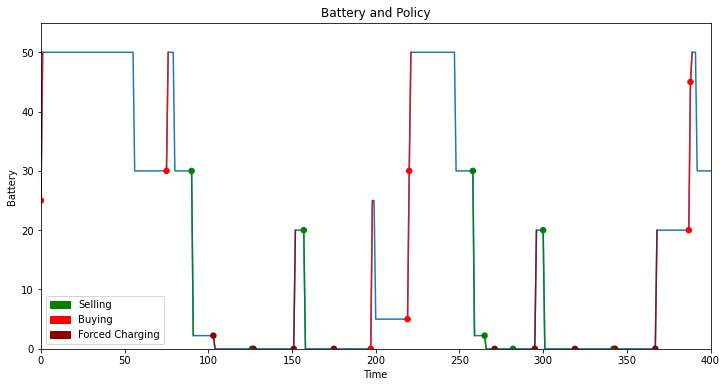

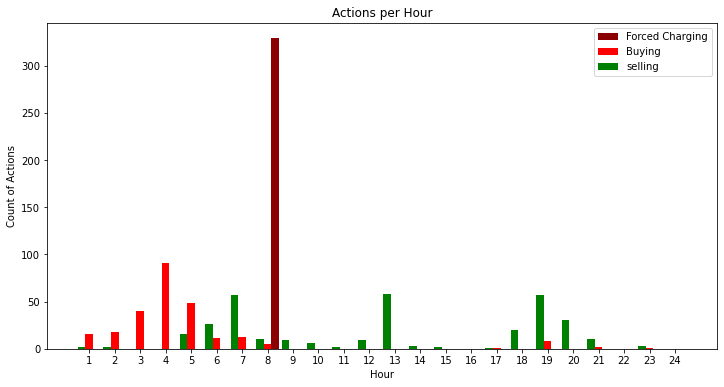

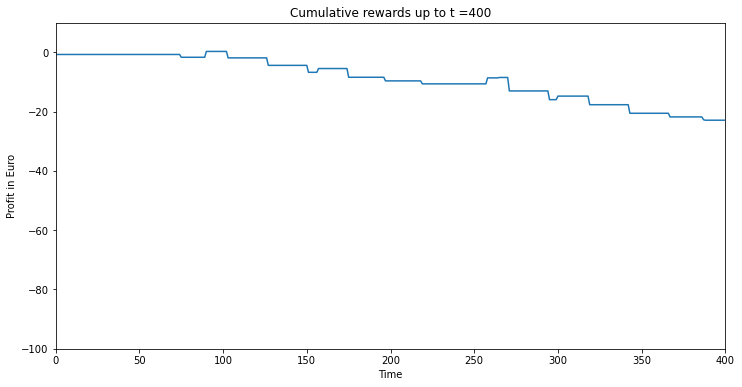

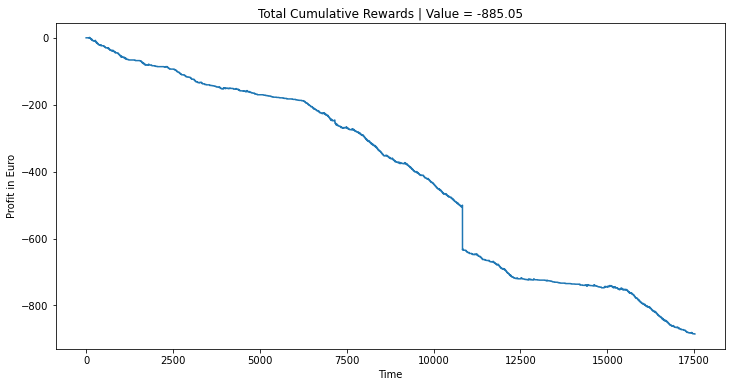

In [5]:
#model.save_Qtable('test.npy')
actions, rewards, states, infos = model.play(data_path_test, plotting=True)

Number of entries 540
Number of zeros 169
Revenue -885.0475420987657
[548016. 435545. 331589.]


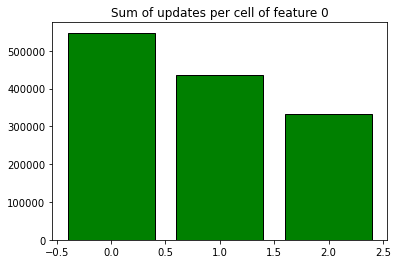

[173750. 500850. 322900. 185900. 131750.]


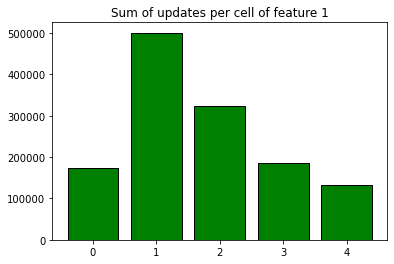

[219200. 219200. 219200. 219200. 219200. 219150.]


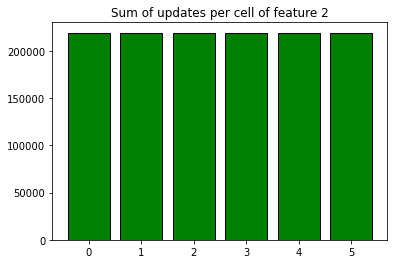

[940750. 374400.]


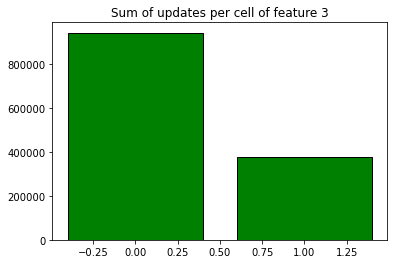

In [6]:
print('Number of entries', model.Qtable.size)
print('Number of zeros', np.sum(model.Qtable==0))
print('Revenue', sum(rewards))

for i in range(len(features_Qtable)):
    axes = list(range(len(features_Qtable)+1))
    axes.remove(axes[i])
    sums = np.sum(model.Qtable_updates, axis=tuple(axes))
    print(sums)
    plt.bar(range(len(sums)), sums, color='green', edgecolor='black')
    plt.title('Sum of updates per cell of feature %d'%features_Qtable[i])
    plt.show()

In [7]:
'''for i in range(100):
    #state : [battery_level, price, int(hour), int(day_of_week), int(day_of_year), int(month), int(year), int(self.car_is_available)]
    print('\nbattery',int(states[i][0]), '  price',int(states[i][1]), '  hour',int(states[i][2]), '  availability',int(states[i][-1]))
    print('action',infos[i])
    print('reward',rewards[i])'''


battery 25   price 13   hour 1   availability 1
action 1.0
reward -0.7333333333333334

battery 50   price 13   hour 2   availability 1
action 0.0
reward -0.0

battery 50   price 11   hour 3   availability 1
action 0.0
reward -0.0

battery 50   price 9   hour 4   availability 1
action 0.0
reward -0.0

battery 50   price 8   hour 5   availability 1
action 0.0
reward 0

battery 50   price 7   hour 6   availability 1
action 0.0
reward 0

battery 50   price 4   hour 7   availability 1
action 0.0
reward 0

battery 50   price 1   hour 8   availability 1
action 0.0
reward 0

battery 50   price 8   hour 9   availability 1
action 0.0
reward -0.0

battery 50   price 9   hour 10   availability 1
action 0.0
reward -0.0

battery 50   price 10   hour 11   availability 1
action 0.0
reward -0.0

battery 50   price 13   hour 12   availability 1
action 0.0
reward -0.0

battery 50   price 18   hour 13   availability 1
action 0.0
reward -0.0

battery 50   price 15   hour 14   availability 1
action 0.0
rew